# Fast Flux Gates on Fluxonium

In [20]:
import kdshmap as kd
import pathos
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scqubits as scq

## The Fluxonium Circuit

In [21]:
EJ   = 3.395
ECJ  = 0.479
EL   = 0.132


fluxonium_yaml =f"""
                  branches:
                  - [JJ, 1,2, EJ = 4.0, 0.450]
                  - [L,  1,2, EL = 0.300]
                """
               
circ = scq.Circuit(fluxonium_yaml, from_file=False, use_dynamic_flux_grouping=True)
circ.set_discretized_phi_range(var_indices=(1,), phi_range=(-4*np.pi, 4*np.pi))
circ.cutoff_ext_1 = 110
#Hierarchical diagonalization to reduce the Hilbert space dimension
circ.Φ1 = 0.5
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[2])

## External Flux Control

### Definition

In [22]:
#Control the external fluxes
def ϕ1_control(t, args):
   """
   Parameters
   ----------

   t : float
            Time

   args : dict
            Dictionary containing the following parameters

            Am : float
                  Amplitude of the flux displacement below the sweet spot 
         
            Ap : float
                  Amplitude of the flux displacement above the sweet spot   
                  
         t_ramp_m : float
                     Time taken to ramp down the flux from the sweet spot
         
         t_wait : float
                     Waiting time between the ramp down and the ramp up
                  
         t_ramp_p : float
                     Time taken to ramp up the flux from the sweet spot

   Returns 
   ------- 
   ϕ1_ext : float 
            External flux at time t 

   """

   Am = args["Am"]
   Ap = args["Ap"]
   t_ramp_m = args["t_ramp_m"]
   t_wait = args["t_wait"]
   t_ramp_p = args["t_ramp_p"]
   
   #Start time for the ramp up
   t_ramp_up_start = 2*t_ramp_m + t_wait
      
   if (t<t_ramp_m):
      ϕ1_ext = 0.5 - t * Am / t_ramp_m
   
   elif t>=t_ramp_m and t<2*t_ramp_m:
      ϕ1_ext = (0.5 - Am) + (t-t_ramp_m)*Am/t_ramp_m
   
   elif t>=2*t_ramp_m and t<t_ramp_up_start:
      ϕ1_ext = 0.5
      
   elif t>=t_ramp_up_start and t<t_ramp_up_start+t_ramp_p:
      ϕ1_ext = 0.5 + (t-t_ramp_up_start)*Ap/t_ramp_p
      
   elif t>=t_ramp_up_start+t_ramp_p and t<t_ramp_up_start+2*t_ramp_p:
      ϕ1_ext = (0.5 + Ap) - (t-t_ramp_up_start-t_ramp_p)*Ap/t_ramp_p
      
   else: ϕ1_ext = 0.5
   
   return ϕ1_ext
      

### Visualization

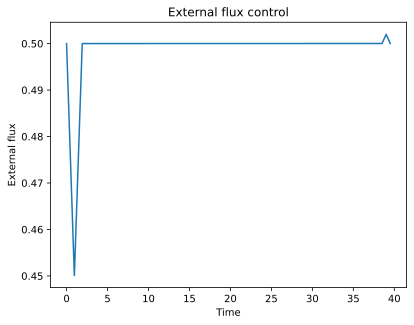

In [23]:
Am = 0.05
Ap = 0.002
t_ramp_m = 0.95
t_wait = 2050/56
t_ramp_p = 0.50

args = {"Am": Am, "Ap": Ap, "t_ramp_m": t_ramp_m, "t_wait": t_wait, "t_ramp_p": t_ramp_p}

t_list = np.linspace(0, 2*t_ramp_m + t_wait + 2*t_ramp_p, 10000)
ϕ1_ext = [ϕ1_control(t, args) for t in t_list]

plt.plot(t_list, ϕ1_ext)
plt.xlabel("Time")
plt.ylabel("External flux")
plt.title("External flux control")
plt.show()

### Expressing the Driven Hamiltonian using Time-Dependent Functions 

In [24]:
#Construct the time-dependent Hamiltonian
H_mesolve, *H_sym_ref = circ.hamiltonian_for_qutip_dynamics(free_var_func_dict={"Φ1":ϕ1_control},
                                                                                 prefactor=2*np.pi)

#H_mesolve is a list. H_mesolve[0] is the time independent part of the Hamiltonian, the other elements are tuples with [drive_operator, time-dependent function] 

In [25]:
#List of the list of values of the drive functions for each drive operator sampled at the tvals in t_list
drive_vals = [] 

for x in H_mesolve[1:]:
   drive_opt  = x[0]
   drive_func = x[1]
   drive_vals.append([drive_func(t, args) for t in t_list])

drive1 = sp.interpolate.CubicSpline(t_list, drive_vals[0])
drive_coeff1 = lambda t, args: float(drive1(t))

drive2 = sp.interpolate.CubicSpline(t_list, drive_vals[1])
drive_coeff2 = lambda t, args: float(drive2(t))
 
H_t = [
       H_mesolve[0], 
       [H_mesolve[1][0], drive_coeff1], 
       [H_mesolve[2][0], drive_coeff2]
      ]
   

### Closed System Gate Simulation : The X Gate

In [26]:
circ.Φ1 = 0.5
eigvals, eigvecs = circ.eigensys(evals_count=2)

zero_05 = q.Qobj(eigvecs[:,0])
one_05  = q.Qobj(eigvecs[:,1])

# ψ0 = (zero_05 + one_05)/np.sqrt(2)
ψ0 = zero_05

proj_0 = zero_05 * zero_05.dag()
proj_1 = one_05 * one_05.dag()

plus   = (zero_05 + one_05)/np.sqrt(2)
minus  = (zero_05 - one_05)/np.sqrt(2)

proj_p = plus * plus.dag()
proj_m = minus * minus.dag()

tlist = np.linspace(0, 2*t_ramp_m + t_wait + 2*t_ramp_p + 1, 1000)

result = q.mesolve(H_t, ψ0, tlist, e_ops=[proj_0, proj_1, proj_p, proj_m])  


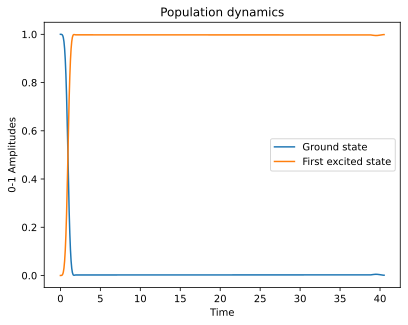

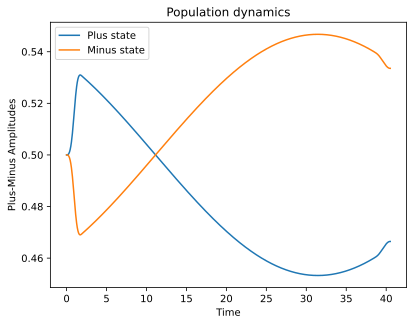

In [27]:
#Plot the expectation values
proj_0_exp = result.expect[0] 
proj_1_exp = result.expect[1]
proj_p_exp = result.expect[2]
proj_m_exp = result.expect[3]

plt.plot(tlist, proj_0_exp, label="Ground state")
plt.plot(tlist, proj_1_exp, label="First excited state")
plt.xlabel("Time")
plt.ylabel("0-1 Amplitudes")
plt.title("Population dynamics")
plt.legend()
plt.show()

plt.plot(tlist, proj_p_exp, label="Plus state")
plt.plot(tlist, proj_m_exp, label="Minus state")
plt.xlabel("Time")
plt.ylabel("Plus-Minus Amplitudes")
plt.title("Population dynamics")
plt.legend()
plt.show()

### Open System Simulation : Keldysh Map

#### 1/f Noise Spectrum

In [28]:
def pink_noise_spd(f, γ, f_ir, f_uv, β):
   """
   Parameters
   ----------
   
   f : float
      Frequency
   
   γ : float
      Scaling factor
         
   f_ir : float
      Infrared cutoff frequency
      
   f_uv : float
      Ultraviolet cutoff frequency
      
   β : float
      Inverse temperature
   
   Returns
   -------
   S : float
      Power spectral density of the pink noise
   """
   
   nth = 0 #thermal factor
   if f>=0:
      nth += 1 + 1/(1 - np.exp(-β*f) + β*f_ir)
   else:
      nth += 1/(1 - np.exp(β*f) + β*f_ir)
      
   S = γ * f_ir/(f**2 + f_ir**2)**(1/2) * np.exp(-f/f_uv) * nth

   return S


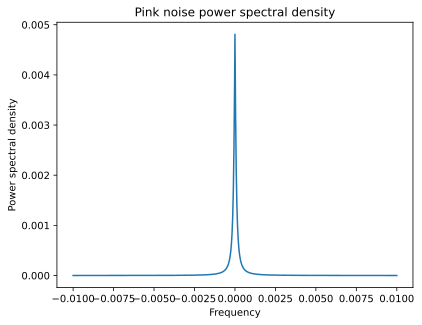

In [70]:
γ = 0.00001
f_ir = 1e-4
f_uv = 1000
β = 20.8366

f_vals  = np.linspace(-0.01, 0.01, 1001)
Sf_vals = [pink_noise_spd(f, γ, f_ir, f_uv, β) for f in f_vals]

plt.plot(f_vals, Sf_vals)
plt.xlabel("Frequency")
plt.ylabel("Power spectral density")
plt.title("Pink noise power spectral density")
plt.show()

In [74]:
# 1/f noise
#Temperature factor
β = 20.8366

#Scaling factor
γ = 0.00001

#Regularization frequencies
f_ir = 1e-3
f_uv = 1000

#Frequencies the spd is sampled at
f_list = np.linspace(-0.1, 0.1, 2001)

Sf_list = np.array([pink_noise_spd(f, γ, f_ir, f_uv, β) for f in f_list])

In [75]:
minimal_step = 0.01
noise_op     = q.Qobj(circ.θ1_operator())  
psi0         = zero_05  
density0     = psi0 * psi0.dag()

solver = kd.KeldyshSolver(H_t, 
                          tlist, 
                          minimal_step, 
                          [noise_op],
                          [f_list], 
                          [Sf_list], 
                          density0=density0,
                          e_ops=[proj_0, proj_1, proj_m, proj_p], trunc_freq=[(-0.1, 0.1)],
                          spd_renorm_method='trapz', 
                          goal='expect')

 /opt/anaconda3/envs/kdshmap/lib/python3.12/site-packages/matplotlib/cbook.py: 1709ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/anaconda3/envs/kdshmap/lib/python3.12/site-packages/matplotlib/cbook.py: 1345

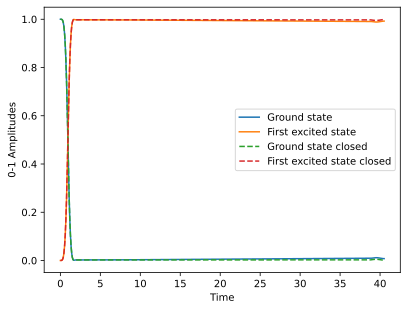

 /opt/anaconda3/envs/kdshmap/lib/python3.12/site-packages/matplotlib/cbook.py: 1709ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/anaconda3/envs/kdshmap/lib/python3.12/site-packages/matplotlib/cbook.py: 1345

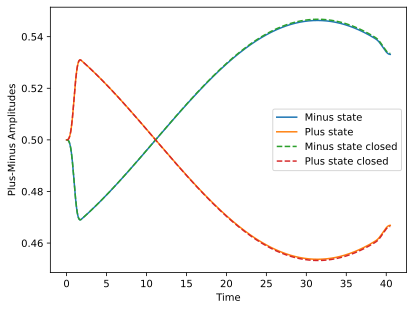

In [76]:
#Plot the expectation valuesin solver.expect[] and the closed system dynamics in proj_._exp

plt.plot(tlist, solver.expect[0], label="Ground state")
plt.plot(tlist, solver.expect[1], label="First excited state")
plt.plot(tlist, proj_0_exp, label="Ground state closed", linestyle="--")
plt.plot(tlist, proj_1_exp, label="First excited state closed", linestyle="--")
plt.xlabel("Time")
plt.ylabel("0-1 Amplitudes")
plt.legend()
plt.show()

plt.plot(tlist, solver.expect[2], label="Minus state")
plt.plot(tlist, solver.expect[3], label="Plus state")
plt.plot(tlist, proj_m_exp, label="Minus state closed", linestyle="--")
plt.plot(tlist, proj_p_exp, label="Plus state closed", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Plus-Minus Amplitudes")
plt.legend()
plt.show()